## Importing Dependencies 

In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import json
from pprint import pprint
import requests
import yfinance as yf
import matplotlib.style as style
from matplotlib.pyplot import figure

style.use('fivethirtyeight')

## Question 2: Is there a recent hype or media attention around "Tech Recession"?

In [2]:
semantics = pd.read_csv("Resources/Semantics.csv")

In [3]:
semantics["Week"] = pd.to_datetime(semantics["Week"])

In [4]:
semantics.set_index("Week", inplace = True)

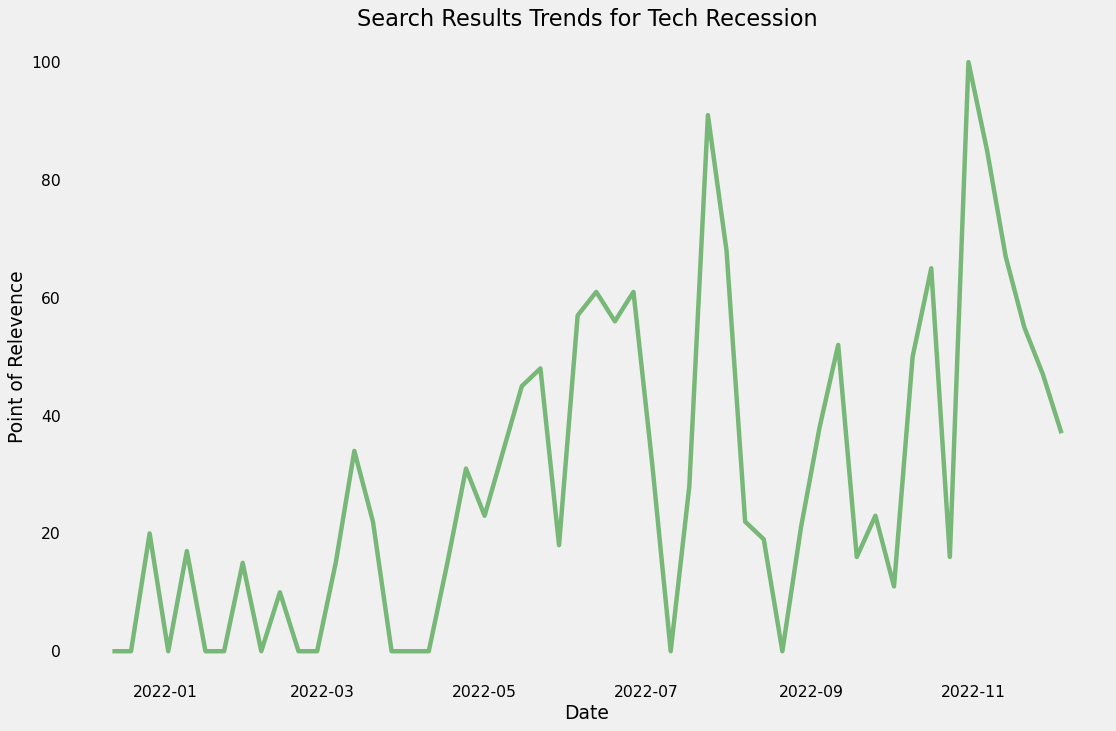

In [5]:
figure(figsize=(15, 10), dpi=80)

plt.plot(semantics["tech recession (USA Search Results)"], color = "green", alpha = 0.5)
plt.title("Search Results Trends for Tech Recession")
plt.xlabel("Date")
plt.ylabel("Point of Relevence")
plt.grid(False)
plt.savefig("Graphs/TechSearchResults.png")
plt.show()

Based on Google Trends, there is recent activity regarding a Tech Recession. What we would like to explore is if there is an actual tech recession or is the media cherry picking on the tech companies. 

In other words, is there statistical significance tech company stocks vs other sectors.

## Reading Output

In [6]:
combine = pd.read_csv("Output/SummaryStockData.csv")

In [8]:
mutiple = ['Price/Book', 'PEG Ratio', 'Foward PE', 'Trailing PE','EV/EBITDA',
          "Total Debt/Equity"]

for column in mutiple:
    combine[column] = combine[column].fillna(0)


In [9]:
Foward_PE = combine[combine["Foward PE"] != 0]

## Question 3: Is there statistical signifance between "Tech" Sectors and others?

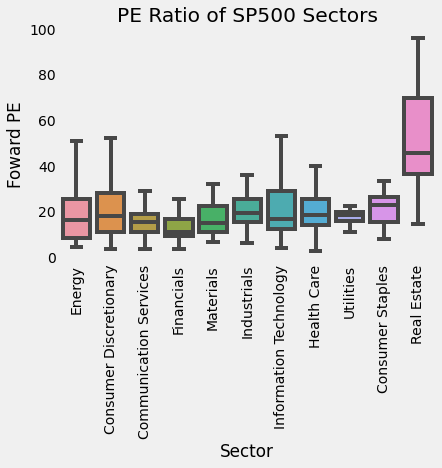

In [19]:
order_sector = ["Energy", "Consumer Discretionary", "Communication Services", 
                        "Financials", "Materials", "Industrials", "Information Technology","Health Care", "Utilities", "Consumer Staples","Real Estate"]

ax = sns.boxplot(data = Foward_PE, x = "Sector", y = "Foward PE", showfliers = False,
                order = order_sector)

ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title("PE Ratio of SP500 Sectors")
plt.grid(False)
plt.savefig("Graphs/Foward_PE.png")
plt.show()

In [17]:
# Anova Test
results = stats.f_oneway(*[list(Foward_PE.loc[Foward_PE['Sector'] == Sector, 
                                              "Foward PE"]) for Sector in order_sector])
print(results)

F_onewayResult(statistic=6.985654329477489, pvalue=2.9166053795038094e-10)


There is statistical significance, and real estate sector is overvalued relative to the other sectors. The tech sectors stocks are valued similar to other sectors. However, what the SP500 classifies as Tech vs. what the media classifies as Tech are different. What if we isolate those, and theh compare against parent sector.

### Further Analysis: Do what the media classifies at Tech demonstrate significance against parent in terms of valuation?

In [20]:
## Reclassification of Stocks 

tech = ["AAPL", "AMZN", "NFLX", "GOOGL", "MSFT", "NVDA", "TSLA"]

technology = Foward_PE.copy()
technology.loc[technology["Symbol"].isin(tech), "Sector"] = "Technology"


technology = technology[technology["Sector"].isin(["Communication Services", 
                                                   "Information Technology", "Consumer Discretionary", "Technology"])]

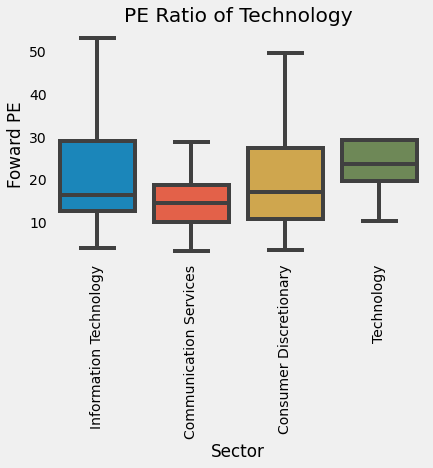

In [21]:
ax = sns.boxplot(data = technology, x = "Sector", y = "Foward PE",
                 orient = "v", showfliers = False)

ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title("PE Ratio of Technology")
plt.grid(False)
plt.savefig("Graphs/Forward_PE_Tech.png")
plt.show()

In [22]:
real = ["Communication Services", "Technology"]

results_final = stats.f_oneway(*[list(technology.loc[technology['Sector'] == Sector, 
                                              "Foward PE"]) for Sector in real])

In [23]:
print(results_final)

F_onewayResult(statistic=0.03524747826283901, pvalue=0.852535558943768)


There is still no statistical significance, but we do see that what the media labels as "Tech", is in the upper 75 quantile compared to their parent sectors.

## Correlation Analysis 

### COVID Data Extraction 

In [24]:
covid = requests.get("https://api.covidtracking.com/v1/us/daily.json").json()

In [25]:
covid_usa = pd.DataFrame(covid)

In [26]:
covid_usa['date'] = covid_usa['date'].astype(str).astype('datetime64')

In [27]:
covid_usa.head()

,date,states,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,lastModified,recovered,total,posNeg,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease,hash
0,2021-03-07,56,28756489.0,74582825.0,11808.0,40199.0,776361.0,8134.0,45475.0,2802.0,...,2021-03-07T24:00:00Z,None,0,0,842,726,131835,41835,1170059,a80d0063822e251249fd9a44730c49cb23defd83
1,2021-03-06,56,28714654.0,74450990.0,11783.0,41401.0,775635.0,8409.0,45453.0,2811.0,...,2021-03-06T24:00:00Z,None,0,0,1680,503,143835,60015,1430992,dae5e558c24adb86686bbd58c08cce5f610b8bb0
2,2021-03-05,56,28654639.0,74307155.0,12213.0,42541.0,775132.0,8634.0,45373.0,2889.0,...,2021-03-05T24:00:00Z,None,0,0,2221,2781,271917,68787,1744417,724844c01659d0103801c57c0f72bf8cc8ab025c
3,2021-03-04,56,28585852.0,74035238.0,12405.0,44172.0,772351.0,8970.0,45293.0,2973.0,...,2021-03-04T24:00:00Z,None,0,0,1743,1530,177957,65487,1590984,5c549ad30f9abf48dc5de36d20fa707014be1ff3
4,2021-03-03,56,28520365.0,73857281.0,11778.0,45462.0,770821.0,9359.0,45214.0,3094.0,...,2021-03-03T24:00:00Z,None,0,0,2449,2172,267001,66836,1406795,fef6c425d2b773a9221fe353f13852f3e4a4bfb0


In [28]:
covid_usa = covid_usa[["date", "hospitalizedCurrently"]]
covid_usa.set_index("date", inplace = True)

### Extraction of Ticker Closing Price

In [29]:
symbol = combine["Symbol"].to_list()

#  time period and interval
yf_period   = "20y"   # 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
yf_interval = "1d"    # 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
#  1.  Create dataframe yf_price with yf.download

yf_returns = yf.download(
        tickers = symbol,       # tickers list or string as well
        period = yf_period,      # optional, default is '1mo'
        interval = yf_interval,  # fetch data by intervaal
        group_by = 'ticker ',     # group by ticker
        auto_adjust = True,      # adjust all OHLC (open-high-low-close)
        prepost = True,          # download market hours data
        threads = True,          # threads for mass downloading
        proxy = None)
#  2.  Select 'Close' (price at market close) column only
yf_returns = yf_returns.iloc[:, yf_returns.columns.get_level_values(1)=='Close']
#  3.  Remove the dataframe multi-index
yf_returns.columns = yf_returns.columns.droplevel(1)  # multi-index


[*********************100%***********************]  505 of 505 completed

15 Failed downloads:
- DISCK: No data found, symbol may be delisted
- KSU: No data found, symbol may be delisted
- CERN: No data found, symbol may be delisted
- VIAC: No data found, symbol may be delisted
- ANTM: No data found, symbol may be delisted
- DISCA: No data found, symbol may be delisted
- BF.B: No data found for this date range, symbol may be delisted
- PBCT: No data found, symbol may be delisted
- WLTW: No data found, symbol may be delisted
- CTXS: No data found, symbol may be delisted
- BLL: No data found, symbol may be delisted
- FB: No data found, symbol may be delisted
- INFO: No data found, symbol may be delisted
- BRK.B: No data found, symbol may be delisted
- XLNX: No data found, symbol may be delisted


### Isolate Test (Tech Stocks vs. Control (rest of stocks))

In [30]:
test = yf_returns[tech]
yf_returns.drop(tech, axis = 1, inplace = True)
control = yf_returns.copy()

In [31]:
correlation = pd.merge(test, covid_usa, left_index = True, right_index = True)

In [32]:
correlation = correlation[correlation["hospitalizedCurrently"].notnull()]



test_correlation = correlation.corr()[["hospitalizedCurrently"]]

## Control 

In [34]:
control_correlation = pd.merge(control, covid_usa, left_index = True, right_index = True)

In [35]:
control_correlation = control_correlation[control_correlation["hospitalizedCurrently"].notnull()]

In [36]:
control_correlation = control_correlation.corr()[['hospitalizedCurrently']]

In [37]:
combine_test = pd.concat([control_correlation, test_correlation])

In [39]:
# Remapping 
remap = combine[["Symbol", "Sector"]]
remap.loc[remap["Symbol"].isin(tech), "Sector"] = "Technology"
remap.set_index("Symbol", inplace = True)

/var/folders/4g/011mcyls15v476x5cqlrm5sm0000gn/T/ipykernel_7464/502820424.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  remap.loc[remap["Symbol"].isin(tech), "Sector"] = "Technology"


In [40]:
combine_test_final = pd.merge(combine_test, remap, left_index = True, right_index = True)
combine_test_final = combine_test_final[combine_test_final["hospitalizedCurrently"].notnull()]

## Question 4. Did tech stocks fall or did all stock stocks fall (relatively) ? 

## Test vs Control

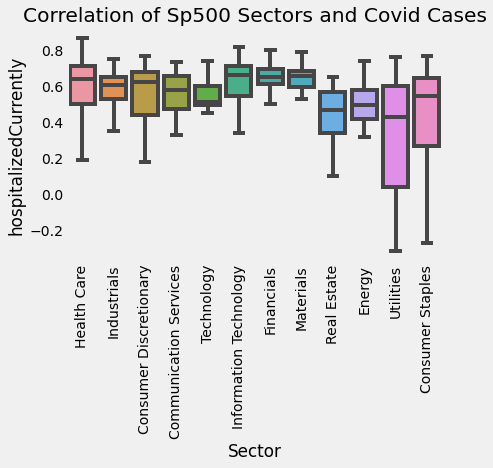

In [57]:
order_covid = ["Health Care", "Industrials", "Consumer Discretionary", "Communication Services", "Technology",
               "Information Technology", "Financials", "Materials", "Real Estate", "Energy", "Utilities", "Consumer Staples"]
               
ax = sns.boxplot(data = combine_test_final, x = "Sector", y = "hospitalizedCurrently", showfliers = False, 
                order = order_covid)
plt.grid(False)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title("Correlation of Sp500 Sectors and Covid Cases")
plt.savefig("Graphs/COVID_TickerPrice.png")

plt.show()
                     

Based on this graph, it seems like all stocks rose with Covid. We hypothesize that is a consequence of printing money during Covid. 

## Mortgage Rate 

In [44]:
## Extraction of mortgage data 
mortgage = pd.read_csv("Resources/Mortgage.csv")

mortgage["DATE"] = pd.to_datetime(mortgage["DATE"])

mortgage = mortgage[mortgage["DATE"] >= "2022-01-01"]
mortgage.set_index("DATE", inplace = True)

In [46]:
mortgage_test = pd.merge(test, mortgage, left_index = True, right_index = True) 

In [47]:
mortgage_test.head()

,AAPL,AMZN,NFLX,GOOGL,MSFT,NVDA,TSLA,MORTGAGE30US
2022-01-06,171.007507,163.253998,553.289978,137.747498,310.966217,281.516754,354.899994,3.22
2022-01-13,171.196411,161.214005,519.200012,138.587006,301.970490,265.501740,343.853333,3.45
2022-01-20,163.560715,151.667496,508.250000,133.307495,298.800171,241.274384,332.089996,3.56
2022-01-27,158.301254,139.637497,386.700012,129.005005,297.056519,219.235001,276.366669,3.55
2022-02-03,171.902313,138.845505,405.600006,143.089996,298.453461,239.256256,297.046661,3.55


### Mortgage Test

In [48]:
mortgage_test_corr = mortgage_test.corr()[["MORTGAGE30US"]]
mortgage_test_corr.head()

,MORTGAGE30US
AAPL,-0.675296
AMZN,-0.804763
NFLX,-0.629420
GOOGL,-0.936928
MSFT,-0.912195


### Mortgage Control

In [50]:
mortgage_control = pd.merge(control, mortgage, left_index = True, right_index = True) 

In [51]:
mortgage_control_corr = mortgage_control.corr()[["MORTGAGE30US"]]

### Mortgage Remap to sector 

In [52]:
combine_mortgage = pd.concat([mortgage_test_corr, mortgage_control_corr])

In [53]:
combine_mortgage_final = pd.merge(combine_mortgage, remap, left_index = True, right_index = True)

In [54]:
combine_mortgage_final = combine_mortgage_final[combine_mortgage_final["MORTGAGE30US"].notnull()]

## Mortgage Test vs Control

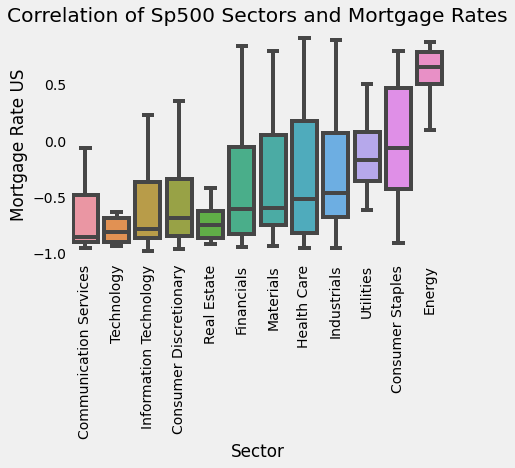

In [58]:
order_mortgage = ["Communication Services", "Technology", "Information Technology", "Consumer Discretionary",
                  "Real Estate", "Financials", "Materials", "Health Care", "Industrials", "Utilities", "Consumer Staples",
                  "Energy"]

ax = sns.boxplot(data = combine_mortgage_final, x = "Sector", y = "MORTGAGE30US", showfliers = False, 
                order = order_mortgage)



ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

plt.title("Correlation of Sp500 Sectors and Mortgage Rates")
plt.ylabel("Mortgage Rate US")
plt.grid(False)
plt.savefig("Graphs/Mortgage_TickerPrice.png")

plt.show()



Most sectors fell during the increase in mortgage rates, and as a result, it seems stocks fell collectively, and this is not limited to the technology sector. 